In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hcleroy/PostDoc/Simulation/Aging_Condensates/Gillespie_backend/')
import Gillespie_backend as backend
from multiprocessing import Pool

In [2]:
def get_position(tmax,dtout,dtreset,S):
  """
  return the linear position of the linkers every dT until tmax
  """
  position = np.zeros((tmax//dtout)-1, dtype= object)
  linkers = np.zeros((tmax//dtout)-1,dtype=object)
  #Nloop = np.zeros(tmax//dt,dtype= int)
  for step in range(tmax):
      if step%dtout==0 and step!=0:
            #print(step)
          #Nloop[step//dt] = S.get_N_loop()
          position[step//dtout-1] = S.get_links_linear_position()
          linkers[step//dtout-1] = S.get_R()
      if step%dtreset == 0 and step!=0:
          S.reset_crosslinkers()
      S.evolve()
  return position,linkers
def dist(a,b):
    try:
        iterator = iter(a)
    except TypeError:
        # not iterable
        return abs(a-b)
    else:
        #iterable
        return 
    
def PairCorrelationFunction(Array,rho0,bins = 10,distmax= None):
    """
    This function return the radial distribution function in any dimension

    Parameter: Array : 
               GillespieSize:
               bins:
               distmax:
    return:
               P:
               R:
    """
    #--------------------------------------------------
    # construct a list of all the neighboring distances
    #--------------------------------------------------
    distances = list()
    for r in Array:
            for R in Array:
                if distmax:
                    if np.linalg.norm(r-R)<distmax:
                        distances.append(np.linalg.norm(r-R))
                else:        
                    distances.append(np.linalg.norm(r-R))
    distances = np.array(distances)
    #--------------------------------------------------
    # Compute the histogram of distances
    #--------------------------------------------------
    H,R  = np.histogram(distances,bins=bins)
    R = np.array([(R[i]+R[i+1])/2 for i in range(R.__len__()-1)]) # re-center the values of the bins
    #--------------------------------------------------
    try:
        iter(Array[0])
    except TypeError:
        Norm=np.array([rho0 for _ in range(R.__len__())])
    else:
        if Array[0].__len__()==2:
            Norm = np.array([2*np.arccos(-1)*r*rho0 for r in R])
        if Array[0].__len__()==3:
            Norm = np.array([4*np.arccos(-1)*r**2*rho0 for r in R])
    return H/Norm,R

def SimulatePairFunction(ttot,dtout,dtreset,ell_tot,rho0,BindingEnergy,seed,repeat,bins=10,distmax=None):
    np.random.seed(seed)
    """"arguments = zip([[ttot for _ in range(repeat)],
                    [dt for _ in range(repeat)],
                    [ell_tot for _ in range(repeat)],
                    [rho0 for _ in range(repeat)],
                    [BindingEnergy for _ in range(repeat)],
                    [np.random.randint(1000000) for _ in range(repeat)]])"""
    arguments = [(ttot,dtout,dtreset,backend.Gillespie(ell_tot,rho0,BindingEnergy,seed=np.randint(100000000))) for _ in range(repeat)]
    with Pool(12) as P:
        # return several time the same simulation with different seed :
        positions,linkers = P.starmap(get_position,arguments)
    positions = np.array(positions)
    linkers = np.array(linkers)
    P,R = np.zeros((positions.shape[1],bins),dtype=float),np.zeros((positions.shape[1],bins),dtype=float)
    for j in range(positions.shape[0]):
        for i in range(positions.shape[1]):
            Pi,R[i] = PairCorrelationFunction(positions[j,i],bins,distmax)
            P[i]+=Pi/repeat
    Plink,Rlink = np.zeros((linkers.shape[1],bins),dtype=float),np.zeros((linkers.shape[1],bins),dtype=float)
    for j in range(linkers.shape[0]):
        for i in range(linkers.shape[1]):
            Pi,Rlink[i] = PairCorrelationFunction(linkers[j,i],bins,distmax)
            Plink[i]+=Pi/repeat
    return P,R,Plink,Rlink

## Simulate the gillespie over time with reset-crosslinkers

In [54]:
BindingEnergy = -200
ell_tot = 200
#distance_anchor = 1000.
rho0 = 1.*10**-4
teq = 1000
t_compute = 1000
reset_linker_time = 100 # number of time per simulation the crosslinkers are reset
seed = 9898654

In [55]:
S = backend.Gillespie(ell_tot,rho0,BindingEnergy,seed)
position,linkers = get_position(1000000,1000,100000,S)

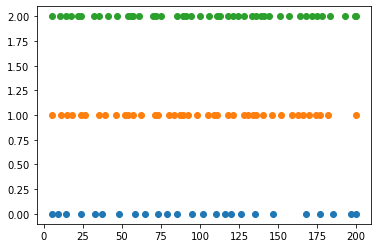

In [56]:
#for i in range(0,position.shape[0],10):
i=2
plt.scatter(position[i],[0 for _ in range(position[i].__len__())])
i=position.__len__()//2
plt.scatter(position[i],[1 for _ in range(position[i].__len__())])
i=-1
plt.scatter(position[i],[2 for _ in range(position[i].__len__())])
plt.show()

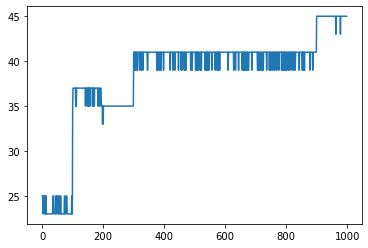

In [57]:
Nloop = np.array([p.__len__() for p in position])
plt.plot(np.arange(0,Nloop.__len__(),1),Nloop)

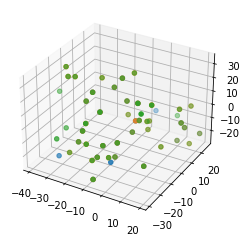

In [58]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(linkers[1][:,0],linkers[1][:,1],linkers[1][:,2])
ax.scatter(linkers[linkers.__len__()//2][:,0],linkers[linkers.__len__()//2][:,1],linkers[linkers.__len__()//2][:,2])
ax.scatter(linkers[-1][:,0],linkers[-1][:,1],linkers[-1][:,2])

In [59]:
g0,r0 = PairCorrelationFunction(linkers[1],rho0)
g1,r1 = PairCorrelationFunction(linkers[linkers.__len__()//2],rho0)
g2,r2 = PairCorrelationFunction(linkers[-1],rho0)

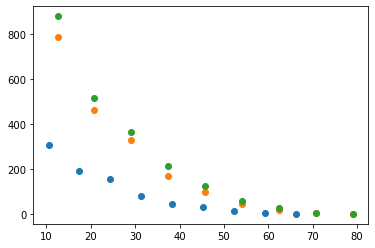

In [60]:
plt.scatter(r0[1:],g0[1:])
plt.scatter(r1[1:],g1[1:])
plt.scatter(r2[1:],g2[1:])

In [61]:
position.shape[0]

999

In [62]:
p0,r0 = PairCorrelationFunction(position[-1],bins = 10,distmax=None)#100)
p1,r1 = PairCorrelationFunction(position[-1],bins = 10,distmax=10)

TypeError: PairCorrelationFunction() missing 1 required positional argument: 'rho0'

In [63]:
plt.plot(r0,p0)
plt.plot(r1,p1)

NameError: name 'p0' is not defined

In [64]:
P,R = SimulatePairFunction(200000,10000,1000,ell_tot,rho0,BindingEnergy,seed,repeat=100,bins=20,distmax=None)

AttributeError: module 'numpy' has no attribute 'randint'

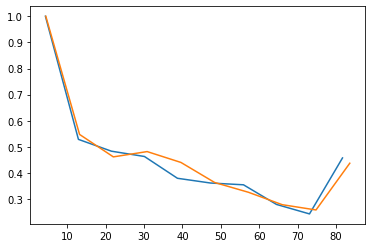

In [140]:
#i=1
plt.plot(R[1],P[1])
plt.plot(R[5],P[5])

In [71]:
A = np.array([1,2,3])
B = np.array([2,3,5])
A+=B
print(A)

[3 5 8]


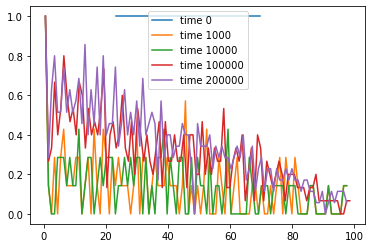

In [86]:

P,R = PairCorrelationFunction(position[0],bins=2)
plt.plot(R,P,label='time 0')
P,R = PairCorrelationFunction(position[1000],100)
plt.plot(R,P,label='time 1000')
P,R = PairCorrelationFunction(position[10000],100)
plt.plot(R,P,label='time 10000')
P,R = PairCorrelationFunction(position[100000],bins=100)
plt.plot(R,P,label='time 100000')
P,R = PairCorrelationFunction(position[-1],bins=100)
plt.plot(R,P,label='time 200000')
plt.legend()